# Project One - Global Terrorism Data
---
Jeff Shamp, John Kellogg, Grace Han - CUNY MSDS 620 - Spring 2021

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('./global_terror_data_proj_1.csv')

## Data

The data is from Global Terrorism Database (GTD) at the University of Maryland.
More information about the database [can be found here](!https://www.start.umd.edu/gtd/).
We will subset this database to only the necessary columns for this project as well as 
subset the start year to 1985 to make the data set more managable. 

### Country, Attack, Target

The first network we will analyze will be comprised of the country in which an act of terror takes place, the attach type (bombing, assassination, etc), and the target of the attack (government building, private citizens, etc). For this project the categorical information will the the target type. 

In [3]:
ter_df = df[["country_txt", "attacktype1_txt", "attacktype1", "targtype1_txt"]]
ter_df.head()

,country_txt,attacktype1_txt,attacktype1,targtype1_txt
0,Sweden,Armed Assault,2,Government (General)
1,West Germany (FRG),Bombing/Explosion,3,Military
2,France,Unknown,9,Police
3,France,Unknown,9,Unknown
4,France,Unknown,9,Unknown


Some very basic information of the constructed network. 

In [4]:
G=nx.from_pandas_dataframe(ter_df, "country_txt", "attacktype1_txt", "targtype1_txt")
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 204
Number of edges: 1226
Average degree:  12.0196


Next we will subsest the data to active war zones in the middle east. 

In [5]:
us_involved = ["Syria", "Turkey", "Iraq","Jordan", 
               "Pakistan", "Afghanistan", "Israel", "Iran"]
ter_df_2 =  ter_df[ter_df.country_txt.isin(us_involved)]
G=nx.from_pandas_dataframe(ter_df_2,
                               "country_txt", 
                               "attacktype1_txt",
                               "targtype1_txt")
ter_df_2.head()

,country_txt,attacktype1_txt,attacktype1,targtype1_txt
16,Israel,Bombing/Explosion,3,Government (General)
17,Israel,Bombing/Explosion,3,Private Citizens & Property
268,Iran,Bombing/Explosion,3,Private Citizens & Property
506,Iran,Bombing/Explosion,3,Government (General)
979,Iran,Bombing/Explosion,3,Private Citizens & Property


This is a fairly large network so viewing it in matplotlib can burdensome. To visualize the network using pyvis please set the below variable `view_pyvis` to `True`. We will further subset the data to make a more viewbale network in following cells.

In [6]:
view_pyvis = False

In [7]:
if view_pyvis:
    N_2 = net.Network(bgcolor='#222222',
                      font_color='white',
                      height='1000px',
                      width='1000px',
                      notebook=True)
    N_2.barnes_hut()
    for n in G.nodes():
        N_2.add_node(n)
    for e in G.edges():
        N_2.add_edge(e[0], e[1])
    N_2.show('active_.html')

### Centrality and Target Type

Next we will look at a few centrality measures of the nodes. First, we will look at the eigenvector centrality, which is a measure of how well connected a node is to other nodes. 

In [8]:
node_1 = [node[0] for node in G.edges()]
node_2 = [node[1] for node in G.edges()]
attr_node = [G.get_edge_data(G.edges()[i][0],
                             G.edges()[i][1])['targtype1_txt']
            for i in range(len(G.edges()))]
data = zip(node_1, node_2, attr_node)
test_df = pd.DataFrame(data=data,
                      columns= ["source", "target", "type"])

In [9]:
eigen_G = nx.eigenvector_centrality_numpy(G)
eigen_sort = sorted(eigen_G.items(),
       key=lambda x:x[1],
       reverse=True)
eigen_df = pd.DataFrame(eigen_sort, 
                        columns=['node', 'eigen_central'])
eigen_df[['node', 'eigen_central']][:10]

,node,eigen_central
0,Pakistan,0.265242
1,Turkey,0.265242
2,Syria,0.265242
3,Iraq,0.265242
4,Afghanistan,0.265242
5,Facility/Infrastructure Attack,0.249362
6,Unknown,0.249362
7,Bombing/Explosion,0.249362
8,Assassination,0.249362
9,Armed Assault,0.249362


Here we see that the countries that are active participants in war are the most central, and that they are tied in eigenvector centrality. One possible exception being Pakistan. It seems the pourous border between Pakistan and Afghanistan, or Syria/Iraq and Turkey might indicate more likely terrorist activities. We should note that this is not the case for all countries. Countries like, Iran, Israel, and Jordan are much further down the list, which makes sense given that they are _less_ involved in the current conflict.

In [10]:
eigen_list = eigen_df[eigen_df.eigen_central >= .24].node.to_list()
eigen_plot_df = test_df[test_df.source.isin(eigen_list)] 

If we filter the network for the most central nodes in this analysis and plot the counts of there respective target type category will see the following.

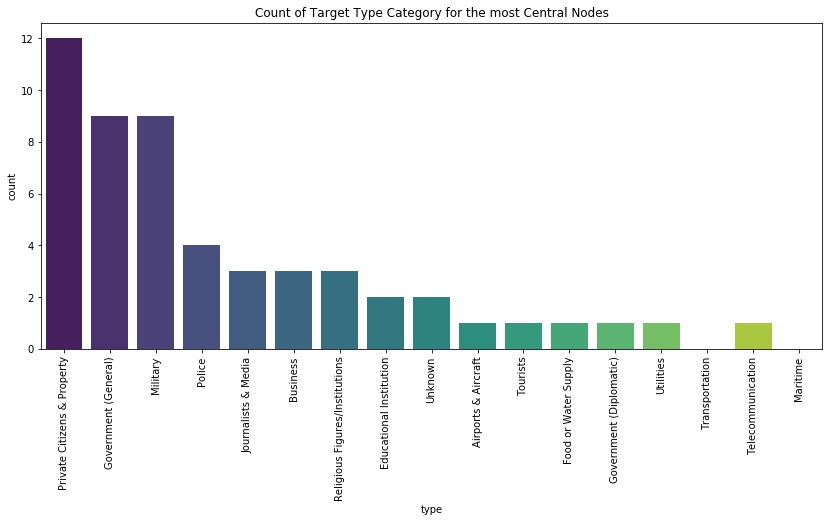

In [11]:
plt.figure(figsize=(14,6))
sns.countplot(data=eigen_plot_df, 
              x='type',
              palette='viridis',
              order=test_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

Attacks against private citizens, the military, and the government make up the three most common target type. 

### Degree Centrality

We will run a similar analysis using degree centrality and compare the results.

In [12]:
degree_G = nx.degree_centrality(G)
degree_sort = sorted(degree_G.items(),
      key=lambda x:x[1], 
      reverse=True)
degree_df = pd.DataFrame(degree_sort, columns=['node', 'degree_central'])
degree_df[degree_df.node.isin(us_involved)]

,node,degree_central
0,Pakistan,0.5625
1,Turkey,0.5625
2,Syria,0.5625
3,Afghanistan,0.5625
4,Iraq,0.5625
5,Israel,0.5000
7,Iran,0.5000
16,Jordan,0.3750


In [13]:
degree_list = degree_df[degree_df.degree_central >= 0.50].node.to_list()
degree_plot_df = test_df[test_df.source.isin(degree_list)] 

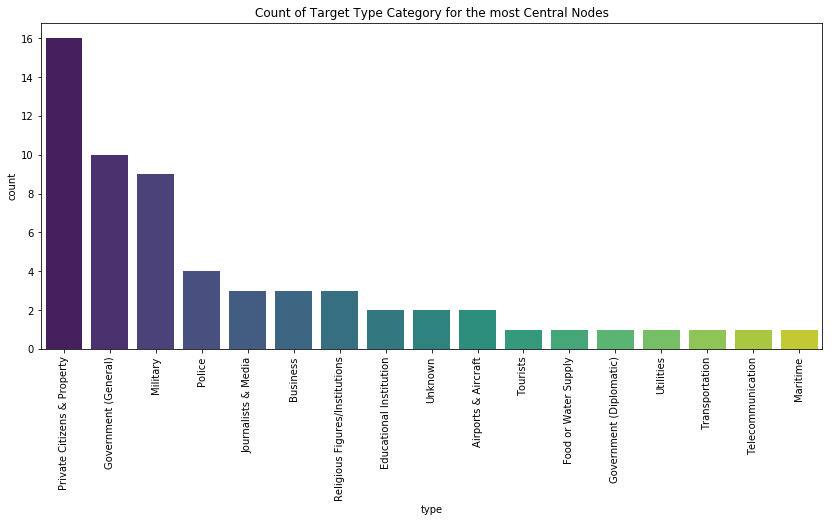

In [14]:
plt.figure(figsize=(14,6))
sns.countplot(data=degree_plot_df, 
              x='type',
              palette='viridis',
              order=test_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

These two metrics; eigenvector centrality and degree centrality produce highly similar distributions of categorical counts. It seems as though this network is _too_ closed for a more meaningful comparison. We do see in the degree centrality are slight further lean for terror acts to be taken against private citizens instead of military installations. 

## Country, Group, Target

We will now shift lenes on this and construct a different network where the nodes are countries and group that attacked that country. We will afix the same target type categorical to each node and run similar metrics.

In [15]:
ter_df = df[["country_txt", "gname", "targtype1_txt"]]
ter_df.head()

,country_txt,gname,targtype1_txt
0,Sweden,Unknown,Government (General)
1,West Germany (FRG),Unknown,Military
2,France,Unknown,Police
3,France,Unknown,Unknown
4,France,Unknown,Unknown


In [16]:
H=nx.from_pandas_dataframe(ter_df, "country_txt", "gname", "targtype1_txt")
print (nx.info(H))

Name: 
Type: Graph
Number of nodes: 3046
Number of edges: 4249
Average degree:   2.7899


In [17]:
us_involved = ["Syria", "Turkey", "Iraq","Jordan", 
               "Pakistan", "Afghanistan", "Israel", "Iran"]
ter_df_2 =  ter_df[ter_df.country_txt.isin(us_involved)]
H=nx.from_pandas_dataframe(ter_df_2,
                               "country_txt", 
                               "gname",
                               ["targtype1_txt"])
ter_df_2.head()

,country_txt,gname,targtype1_txt
16,Israel,Unknown,Government (General)
17,Israel,Unknown,Private Citizens & Property
268,Iran,Unknown,Private Citizens & Property
506,Iran,Mujahedin-e Khalq (MEK),Government (General)
979,Iran,Unknown,Private Citizens & Property


To view the network in pyvis toggle to `True`.

In [18]:
view_pyvis = True

In [20]:
if view_pyvis:
    M = net.Network(height='1000px',
                    width='1000px',
                    bgcolor='#222222', 
                    font_color='white', 
                    notebook=True)
    M.barnes_hut()
    for n in H.nodes():
        M.add_node(n)
    for e in H.edges():
        M.add_edge(e[0], e[1])
    M.show('network_2.html')

NameError: name 'net' is not defined

In [21]:
node_1 = [node[0] for node in H.edges()]
node_2 = [node[1] for node in H.edges()]
attr_node = [H.get_edge_data(H.edges()[i][0],
                             H.edges()[i][1])['targtype1_txt']
            for i in range(len(H.edges()))]
data = zip(node_1, node_2, attr_node)
test_df_2 = pd.DataFrame(data=data,
                      columns= ["source", "target", "type"])

In [22]:
eigen_H = nx.eigenvector_centrality_numpy(H)
eigen_sort = sorted(eigen_H.items(),
       key=lambda x:x[1],
       reverse=True)
eigen_df = pd.DataFrame(eigen_sort, 
                        columns=['node', 'eigen_central'])
eigen_df[['node', 'eigen_central']][:10]

,node,eigen_central
0,Pakistan,0.643762
1,Iraq,0.190405
2,Afghanistan,0.134182
3,Turkey,0.109138
4,Unknown,0.109030
5,Muslim extremists,0.109030
6,Gunmen,0.100933
7,Syria,0.092835
8,Islamist extremists,0.090647
9,Militants,0.078482


With this new network that connects country to responsible group name we see that Pakistan is a much more central node. That is, it's eigenvector centrality is three times as large as the next nearest node. This means that Pakistan is connected to nodes that are well-connected. 

In [23]:
eigen_list = eigen_df.node.to_list()[:10]
eigen_plot_df = test_df_2[test_df_2.source.isin(eigen_list)] 

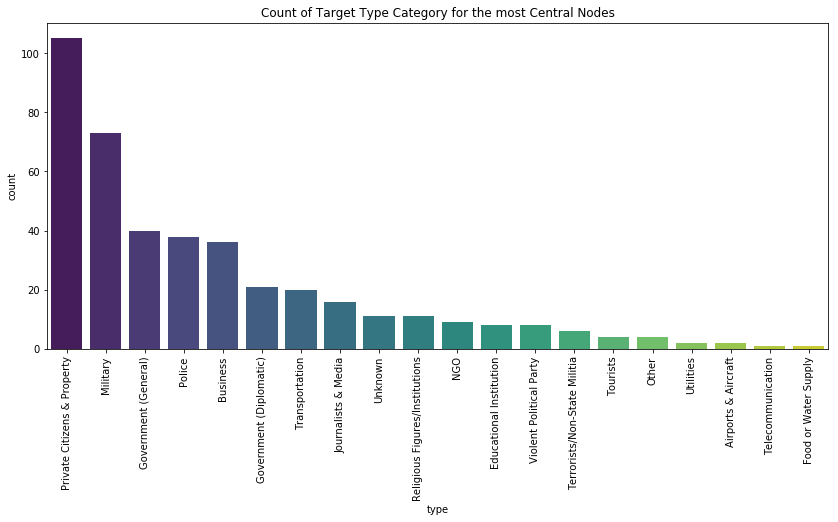

In [24]:
plt.figure(figsize=(14,6))
sns.countplot(data=eigen_plot_df, 
              x='type',
              palette='viridis',
              order=eigen_plot_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

We see here that for the categorical target type attacks against private citizens and military installations is starting to pull away from the other target types. 

In [25]:
degree_H = nx.degree_centrality(H)
degree_sort = sorted(degree_H.items(),
      key=lambda x:x[1], 
      reverse=True)
degree_df = pd.DataFrame(degree_sort, columns=['node', 'degree_central'])
degree_df[['node', 'degree_central']][:10]

,node,degree_central
0,Pakistan,0.306695
1,Iraq,0.213823
2,Syria,0.159827
3,Israel,0.144708
4,Turkey,0.136069
5,Afghanistan,0.092873
6,Iran,0.082073
7,Jordan,0.038877
8,Unknown,0.017279
9,Muslim extremists,0.017279


In [26]:
degree_list = degree_df.node.to_list()[:5]
degree_plot_df = test_df_2[test_df_2.source.isin(degree_list)] 

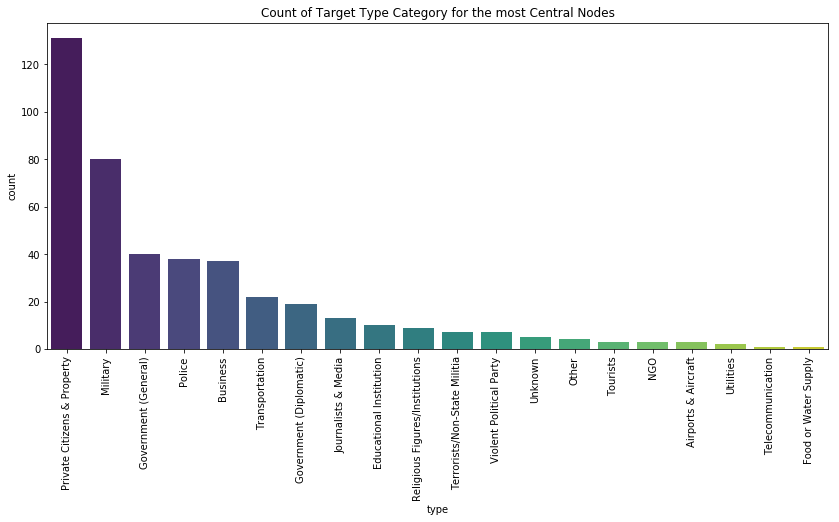

In [27]:
plt.figure(figsize=(14,6))
sns.countplot(data=degree_plot_df, 
              x='type',
              palette='viridis',
              order=degree_plot_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

And a similar result is shown with degree centrality. The rate of attack against a given target type is rising almost quadratically. 

In [ ]:
# tried to draw node based on color as well for the first network while retaining the categorcal text. 
# I failed. 

# plt.figure(figsize=(15,15))
# targets = set(degree_plot_df.source.unique())
# target_dict = nx.get_edge_attributes(G, 'targtype1_txt')
# colors = [plt.cm.Set1(x) for x in np.linspace(0,1,len(targets))]
# pos = nx.spring_layout(G)

# for i, target in enumerate(targets):
#     target_nodes = [node for node, value in target_dict.items() if value == target]
#     nx.draw_networkx_nodes(G, pos,
#                            nodelist=target_nodes, 
#                            node_color=colors[i],
#                            label=target,
#                            with_labels=False,
#                            node_size=10000,
#                            cmap=plt.cm.Set1)
# nx.draw_networkx_edges(G, pos, alpha=0.3)
# plt.axis('off')
# plt.show()

## Targets, Groups, and the weapons used

The third network we wanted to analyze is breaking down the other two and giving us a brief look at the targets the terror groups attacked and the weapons used.  Our focus is the most prolific groups and which target types they attack.     

In [31]:
# pairing down the main dataframe
target_org = df[['targtype1_txt', 'gname', 'weaptype1_txt']]
target_org = target_org[target_org['gname']!= "Unknown"]
#target_org.head()

In [66]:
#defining the top 5 groups
n=5
top_gname = target_org['gname'].value_counts()[:n].index.tolist()
target_org_small =  target_org[target_org.gname.isin(top_gname)]

S=nx.from_pandas_dataframe(target_org_small, 
                           "weaptype1_txt",
                           "gname", 
                           "targtype1_txt")
target_org_small.head()

,targtype1_txt,gname,weaptype1_txt
19,Private Citizens & Property,Shining Path (SL),Firearms
20,Government (General),Shining Path (SL),Firearms
21,Private Citizens & Property,Shining Path (SL),Firearms
25,Utilities,Shining Path (SL),Explosives
26,Utilities,Shining Path (SL),Explosives


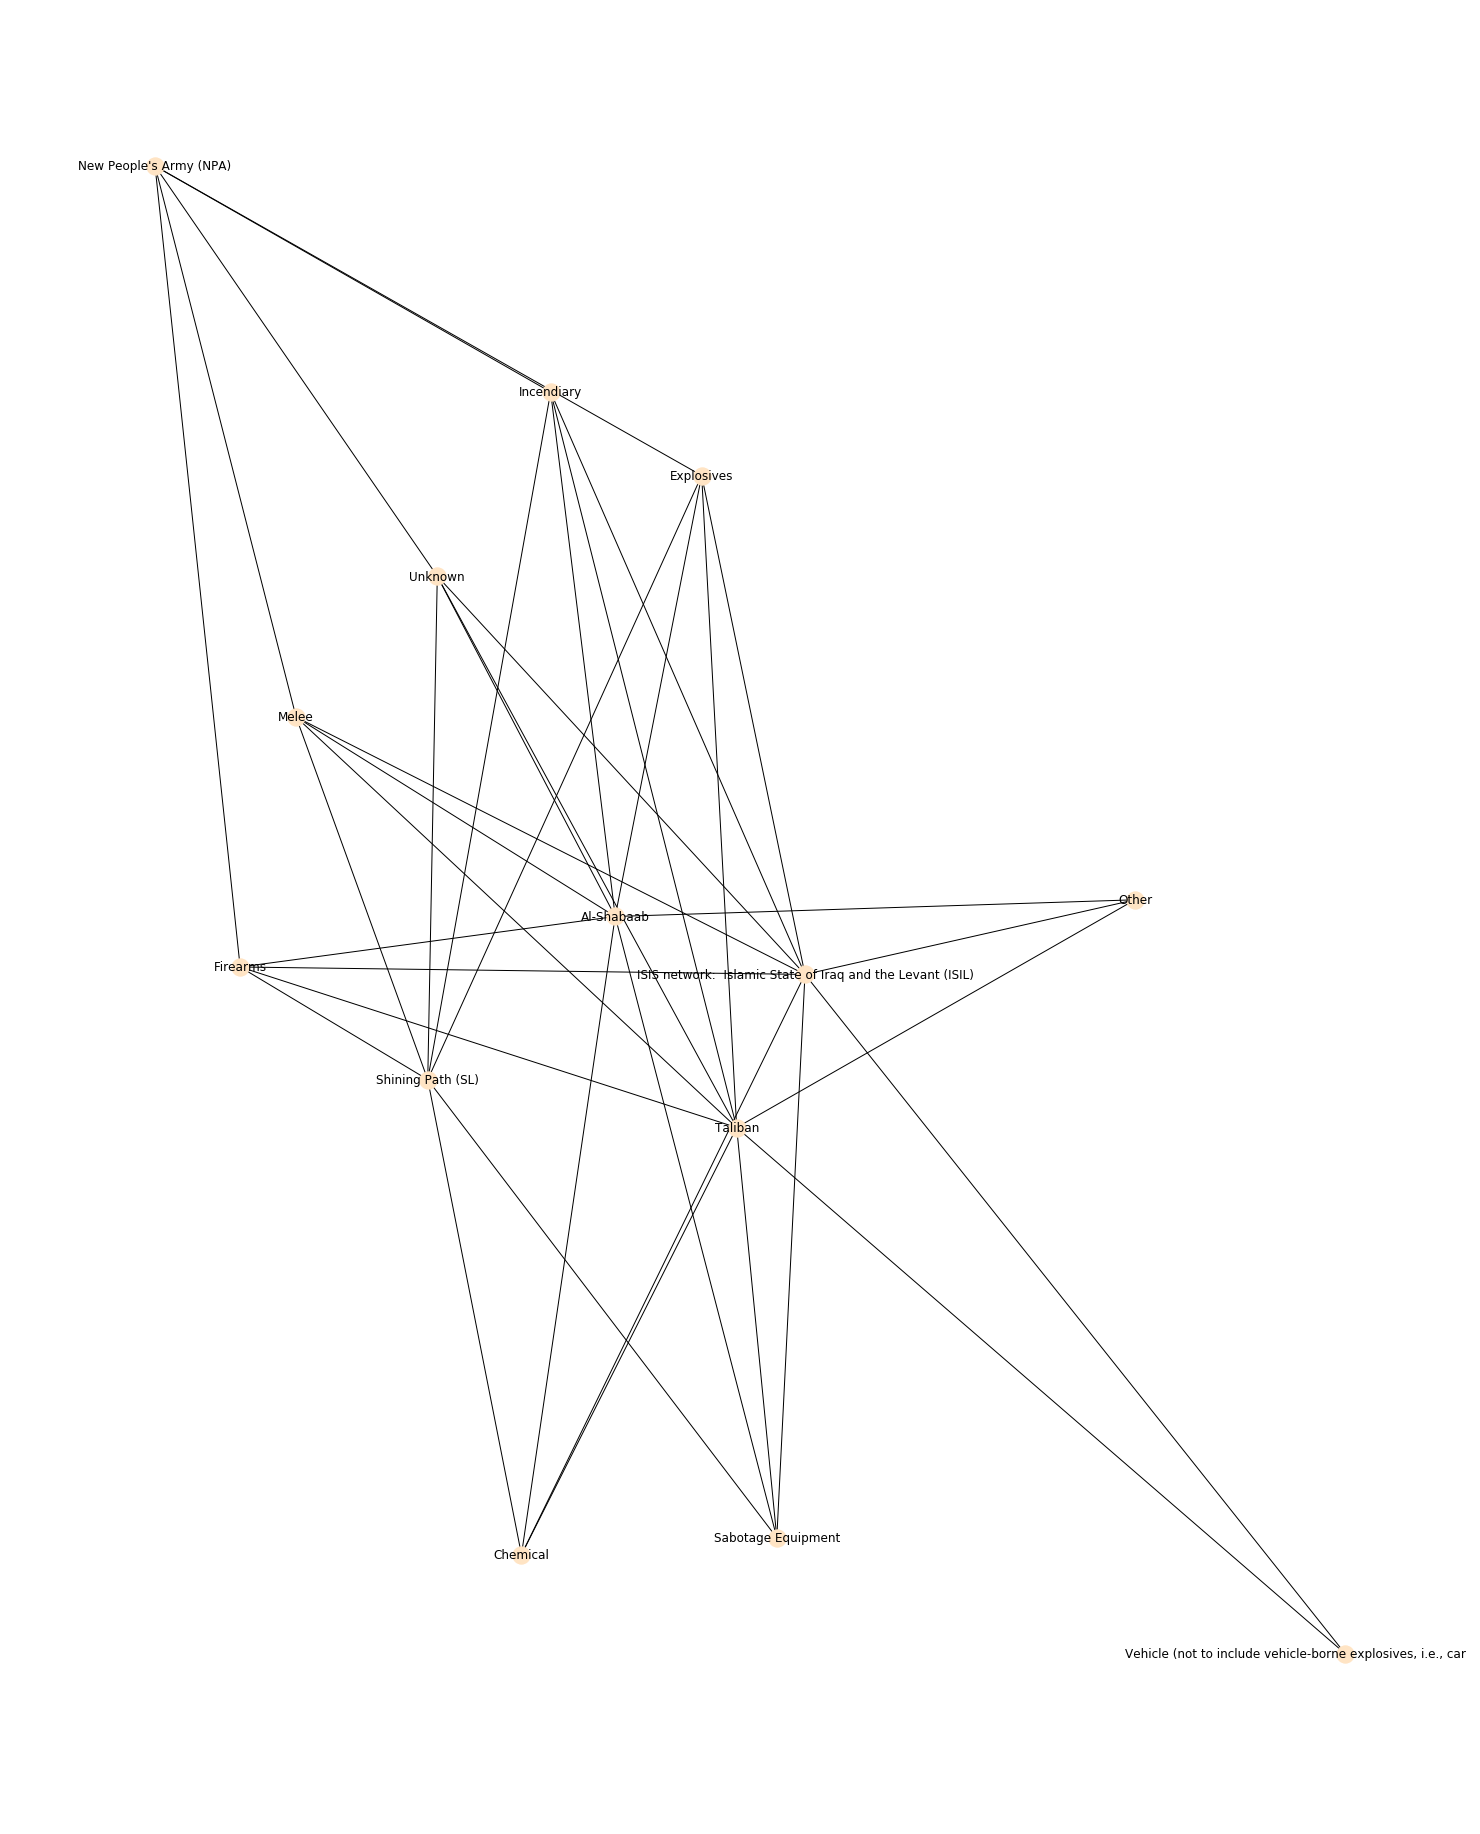

In [80]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 25)
nx.draw(S, node_color='bisque', with_labels=True)

Most of the Top 5 groups all affect the same type of targets.  The exception to this rule is Violent Political Parties.

In [68]:
eigen_S = nx.eigenvector_centrality_numpy(S)
eigen_sort = sorted(eigen_S.items(),
       key=lambda x:x[1],
       reverse=True)
eigen_df = pd.DataFrame(eigen_sort, 
                        columns=['node', 'eigen_central'])
eigen_df[['node', 'eigen_central']][:10]

,node,eigen_central
0,ISIS network: Islamic State of Iraq and the L...,0.352143
1,Taliban,0.352143
2,Al-Shabaab,0.331869
3,Shining Path (SL),0.302042
4,Firearms,0.265222
5,Explosives,0.265222
6,Unknown,0.265222
7,Melee,0.265222
8,Incendiary,0.265222
9,Sabotage Equipment,0.227048


In [70]:
node_1 = [node[0] for node in S.edges()]
node_2 = [node[1] for node in S.edges()]
attr_node = [S.get_edge_data(S.edges()[i][0],
                             S.edges()[i][1])['targtype1_txt']
            for i in range(len(S.edges()))]
data = zip(node_1, node_2, attr_node)
test_df_3 = pd.DataFrame(data=data,
                      columns= ["source", "target", "type"])

In [74]:
eigen_list = eigen_df.node.to_list()[:5]
eigen_plot_df = test_df[test_df.source.isin(eigen_list)] 

In [77]:
degree_S = nx.degree_centrality(S)
degree_sort = sorted(degree_S.items(),
      key=lambda x:x[1], 
      reverse=True)
degree_df = pd.DataFrame(degree_sort, columns=['node', 'degree_central'])
degree_df[['node', 'degree_central']][:10]
degree_list = degree_df.node.to_list()[:5]
degree_plot_df = test_df_3[test_df_3.source.isin(degree_list)] 

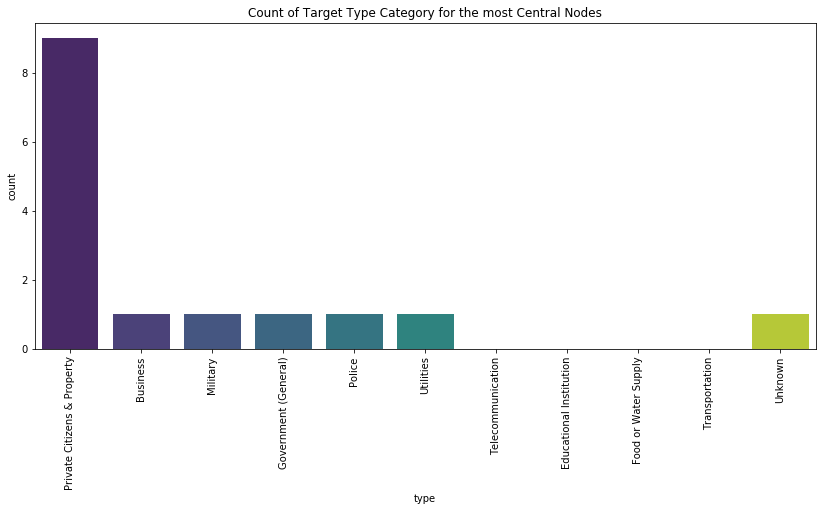

In [78]:
plt.figure(figsize=(14,6))
sns.countplot(data=degree_plot_df, 
              x='type',
              palette='viridis',
              order=test_df_3.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

As expected, the top 5 groups have near to the same centrality. The type of attack also has the same centrality.  It is interesting only the Taliban and ISIS use vehicle.    

## Final Thoughts